# 先端機械学習2022中間レポート Problem 4
hinge損失+L1正則化に基づいた二値分類サポートベクターマシンを近接勾配法（Proximal (sub)-gradient）で実装し、その線型計画問題をcvxで解いて得られた解にこの実装で得られた解が近づいている事を確認し、最後に正則化項の係数を大きくすることでスパースな解が得られることを確認する。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

In [2]:
def generate_data():
  # toy dataset 4
  n = 200
  x = 3 * (np.random.rand(n, 4) - 0.5)
  y = (2 * x[:,0] - 1 * x[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
  y = 2 * y - 1
  return n, x, y
def plot_2Ddata(x, y):
  # 二次元データ点の描画
  plt.plot(np.extract(y>0,x[:,0]),np.extract(y>0,x[:,1]), 'x')
  plt.plot(np.extract(y<0,x[:,0]),np.extract(y<0,x[:,1]), 'o')

In [3]:
def solve_by_cvx(x, y, lam):
  n = len(x)
  d = x.shape[1] + 1
  x = np.hstack([x, np.ones((n,1))]) # オフセットのために1を追加
  # w_i, xi_i, e_i
  c = np.hstack([np.zeros(d), np.ones(n), lam * np.ones(d)])
  # 制約の係数行列(n+d+d+n+d, d+n+d)
  A = np.vstack([
        np.hstack([y[:,np.newaxis] * x, np.eye(n), np.zeros((n,d))]),
        np.hstack([np.eye(d), np.zeros((d,n)), np.eye(d)]),
        np.hstack([-np.eye(d), np.zeros((d,n)), np.eye(d)]),
        np.hstack([np.zeros((n,d)), np.eye(n), np.zeros((n,d))]),
        np.hstack([np.zeros((d,d)), np.zeros((d,n)), np.eye(d)]),
  ])
  b = np.hstack([np.ones(n), np.zeros(d+d+n+d)])
  z = cv.Variable((d+n+d,))
  obj = cv.Minimize(c.T @ z)
  constraints = [A @ z >= b]
  prob = cv.Problem(obj, constraints)
  result = prob.solve(solver=cv.CVXOPT)
  z = z.value
  w, xi, e = z[:d], z[d:d+n], z[d+n:d+n+d]
  return w

In [4]:
def svm(x, y, lam):
  """
  L1正則化とhinge損失のSVMをProximal gradientで解く
  """
  n = len(x)
  d = x.shape[1] + 1
  x = np.hstack([x, np.ones((n,1))])
  w = np.zeros(d)
  # X = (y_i*x_i^T)_i
  X = y[:, np.newaxis] * x

  # Backtrackingで用いるパラメータ
  rho = 0.6
  c1 = 0.01
  MAX_BACKTRACKING = 20
  w_history = []
  loss_history = []
  for _ in range(MAX_ITERATION):
    # 記録
    loss = np.sum(np.max(1 - np.dot(X, w)[:, np.newaxis], initial=0, axis=1)) \
        + lam * np.sum(np.abs(w))
    w_history.append(w)
    loss_history.append(loss)
    # 更新
    # y_iw^Tx_i > 1なら更新しない
    use = np.dot(X, w) <= 1
    grad = - np.sum(use[:, np.newaxis] * X, axis=0)
    ## Backtracking
    eta = 1
    dot = np.dot(grad, grad)
    for _ in range(MAX_BACKTRACKING):
      thd = lam * eta
      soft_thresholding = np.vectorize(lambda w: w - thd if w > thd else (w + thd if w < -thd else 0))
      w_next = soft_thresholding(w - eta * grad)
      loss_next = np.sum(np.max(1 - np.dot(X, w_next)[:, np.newaxis], initial=0, axis=1)) \
        + lam * np.sum(np.abs(w_next))
      # Armijo
      if loss_next <= loss - c1 * eta * dot:
        break
      eta = rho * eta
    thd = lam * eta
    soft_thresholding = np.vectorize(lambda w: w - thd if w > thd else (w + thd if w < -thd else 0))
    w = soft_thresholding(w - eta * grad)

  return w, w_history, loss_history

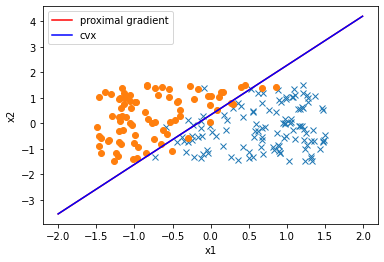

In [5]:
np.random.seed(1024)

MAX_ITERATION = 10000
n, x, y = generate_data()
lam = 1
w, w_history, loss_history = svm(x, y, lam)

# cvxで解く
w_cvx = solve_by_cvx(x, y, lam)

# 仮にw[:2]までを使ったときの決定境界を描画
plot_2Ddata(x, y)
xs = np.arange(-2,2,0.01)
ys = (-w[0]*xs-w[-1])/w[1]
plt.plot(xs, ys, label="proximal gradient", color="red")
xs = np.arange(-2,2,0.01)
ys = (-w_cvx[0]*xs-w_cvx[-1])/w_cvx[1]
plt.plot(xs, ys, label="cvx", color="blue")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

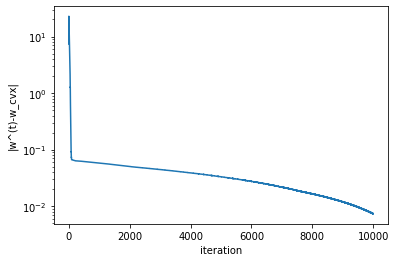

In [6]:
# cvxpyで求めたwへの距離|w^(t)-w_cvx|を描画
plt.yscale("log")
plt.ylabel("|w^(t)-w_cvx|")
plt.xlabel("iteration")
plt.plot(np.sum(np.abs(w_cvx-w_history), axis=1))
#w, w_cvx

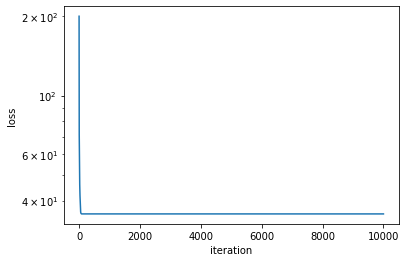

In [7]:
plt.yscale("log")
plt.ylabel("loss")
plt.xlabel("iteration")
plt.plot(loss_history)

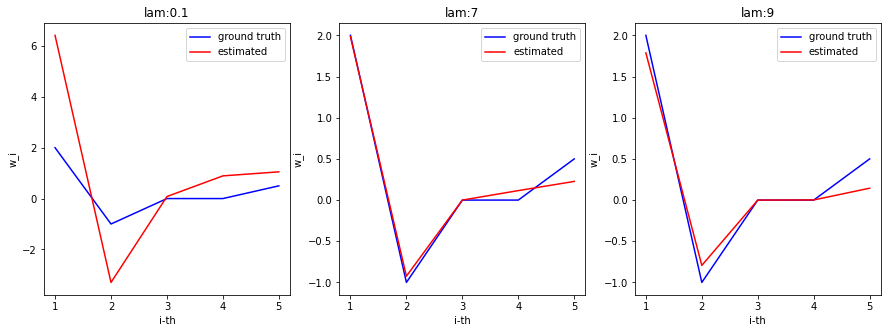

In [8]:
# lamを大きくすると幾つかのパラメータが0になりスパースな解が求まることを確認
np.random.seed(1024)

MAX_ITERATION = 10000
n, x, y = generate_data()
lams = [0.1,7,9]
w_for_lam = []
for lam in lams:
  w, w_history, loss_history = svm(x, y, lam)
  w_for_lam.append(w)
w_ground_truth = np.array([2, -1, 0, 0, 0.5])
fig = plt.figure(figsize=(5*len(lams),5))
for i in range(len(lams)):
  lam = lams[i]
  w = w_for_lam[i]
  ax = fig.add_subplot(1,len(lams),i+1)
  ax.plot(np.arange(1,len(w)+1), w_ground_truth, "b-", label="ground truth")
  ax.plot(np.arange(1,len(w)+1), w, "r-", label=f"estimated")
  ax.set_title(f"lam:{lam}")
  ax.set_ylabel("w_i")
  ax.set_xlabel("i-th")
  ax.legend()